In [4]:
from src.utils import draw, draw_trajectories, get_modules, get_directional, plot_inputs
from src.simulation import simulation
from src.PIDController import PID_Controller

In [5]:
import numpy as np

from tqdm import trange

# System definition

## Starting state

- First tuple: $(x, y)$
- Second tuple: $(x_{speed}, y_{speed})$
- Angle in degree

In [6]:
start   = [(100, 100), (0, 0), 0]

## Target state

- First tuple: $(x, y)$
- Second tuple: $(x_{speed}, y_{speed})$
- Angle in degree

In [7]:
# targets = np.array([[500, 400, 0, 0],
#                     [400, 700, 0, 0],
#                     [800, 800, 0, 0],
#                     [900, 900, 0, 0]
                   # ])
targets = np.array([
                    [150, 125, 0, 0],
                    [400, 700, 0, 0],
                    [700, 500, 0, 0],
                    [900, 900, 0, 0],
                   ])

## Obstacles state

- First tuple: $(x, y)$
- Angle in degree

In [8]:
obstacles = [[(300, 350), 0], 
             [(600, 400), 0],
             [(600, 600), 0],
             [(800, 700), 0]
            ]
# obstacles = []

## Noise

Possible noise that can be used
$$(x, y, x_{speed}, y_{speed})$$

In [9]:
# noise         = [3, 3, 1e-16, 1e-16]
# noise         = [1e-16, 1e-16, 0.25, 0.25]
noise         = [1]*4
# noise         = [1e-16, 1e-16, 1e-16, 1e-16]

# PID Optimization

Requires some time, to speed-up the process some nice values were found
- One when using Kalman filter
- One when using Luemberger Observer

In [10]:
initial_guess = [0.5, 0.5, 0.5]   

# LQR = True
LQR = False

# kalman = True
kalman = False

use_PID = True
# use_PID = False

## Optimization

In [11]:
if use_PID:
    PID = PID_Controller(start, obstacles, targets, reference=0, simulation_time=1000, kalman=kalman, noise=noise, LQR=LQR)
    K   = PID.optimize_pid(initial_guess)
    Kp, Ki, Kd = K

    print(K)
else:
    PID = None
    Kp, Ki, Kd = 0, 0, 0

/home/nefasto/Documents/CPS/CPS_Project/src/collisions.py:203: RuntimeWarning: invalid value encountered in divide
  axes = axes / np.linalg.norm(axes, axis=1)[:, None]


[6.9799101  8.95424647 2.36728285]


In [45]:
# PID = PID_Controller(start, obstacles, targets, reference=0, simulation_time=1000, kalman=kalman, noise=noise)
# Kp, Ki, Kd = [-0.06302686, -0.00795151, -4.38283884]

In [46]:
# tollerated-noise
# NO-PID-KALMAN: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 
# NO-PID-LUENBE: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 

# To fix (?)
# PID-LUENBE: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 
# PID-KALMAN: 
#                [0, 0, 0, 0] -> [0, 0, 4, 4] 
#                [0, 0, 0, 0] -> [7, 7, 0, 0] 

# Simulations

In [47]:
# Kp, Ki, Kd = [-0.11052183,  0.51122139, -0.08594941]

In [12]:
simulations = 100
simulation_time = 2000
dt = 0.5

states        = np.zeros((simulations, int(simulation_time/dt) + 1, 4))
u_list        = np.zeros((simulations, int(simulation_time/dt), 2))
reference_list= np.zeros((simulations, int(simulation_time/dt), 2))
theta_list    = np.zeros((simulations, int(simulation_time/dt)))

has_completed = np.zeros((simulations))
has_collided  = np.zeros((simulations))

bar = trange(simulations)

for i in bar:
    states[i], u_list[i], target_list, reference_list[i], theta_list[i], has_completed[i], has_collided[i], frames = simulation(start, obstacles, targets, PID, Kp=Kp, Ki=Ki, Kd=Kd, simulation_time=simulation_time, kalman=kalman, noise=noise, reference=0, dt=dt, LQR=LQR)
    bar.set_postfix({"has_completed": np.mean(has_completed[:i]), "has_collided": np.mean(has_collided[:i])})

  0%|                                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]/home/nefasto/Documents/CPS/CPS_Project/CPS_Project/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nefasto/Documents/CPS/CPS_Project/CPS_Project/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it, has_completed=1, has_collided=0.121]


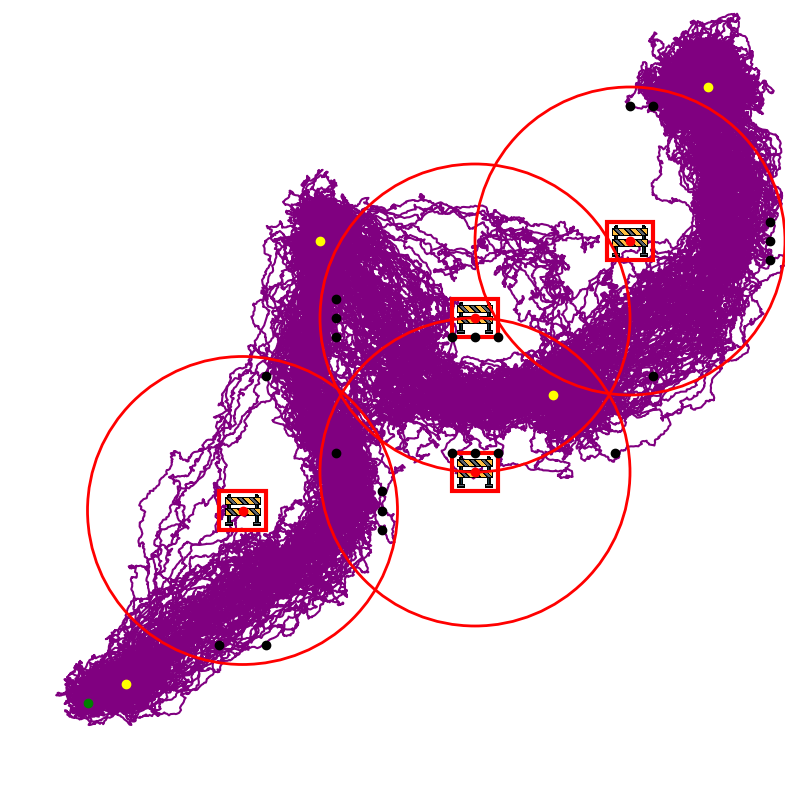

In [13]:
ax = draw_trajectories(obstacles, start, targets, states, target_list)

In [14]:
has_completed.mean()

np.float64(1.0)

In [15]:
has_collided.mean()

np.float64(0.12)

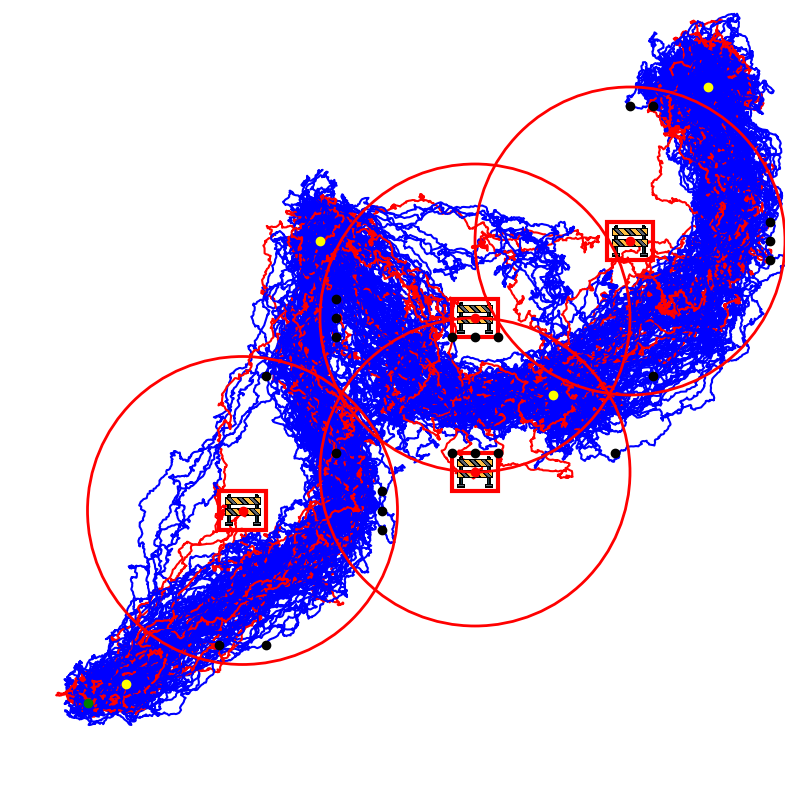

In [16]:
from src.Obstacle import Obstacle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Initialize the Obstacles
obstacles_draw = np.array([Obstacle(coords, angle) for coords, angle in obstacles])

# Initialize the plot
image_size = 1000
fig = plt.figure(figsize=(image_size / 100, image_size / 100), dpi=100)
ax = plt.gca()
ax.axis('off')

ax.set_xlim(0, image_size)
ax.set_ylim(0, image_size)

# Plot the trajectories
colors = ["blue" if completed and not collided else "red" for completed, collided in zip(has_completed, has_collided)]
for state, color in zip(states, colors):
    ax.plot(state[:, 0], state[:, 1], color=color)

# Plot the starting position
ax.scatter(start[0][0], start[0][1], color="green", zorder=10)

# Plot the obstacles and relative detection boundings
for obstacle in obstacles_draw:
    obstacle.draw(ax)
    ax.add_patch(Circle(obstacle.get_coords(), 200, lw=2, facecolor="None", edgecolor="red", zorder=10))

# Plot the target position
ax.scatter(targets[:, 0], targets[:, 1], color="yellow", zorder=10)

if len(target_list) > 0:
    # Plot the temporaneous target positions
    ax.scatter(target_list[:, 0], target_list[:, 1], color="black", zorder=10)

# Show the plot
plt.show()

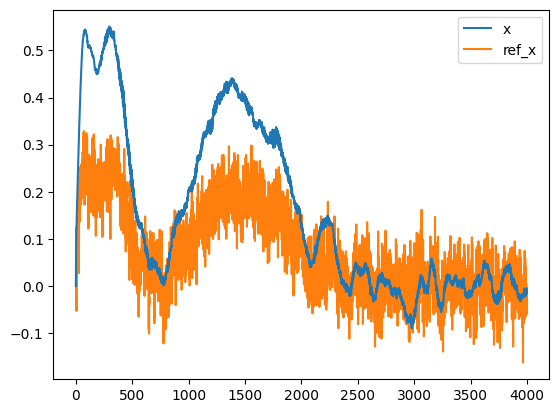

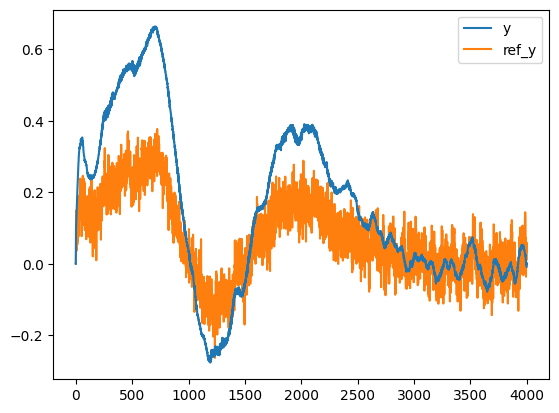

In [17]:
plot_inputs(u_list, reference_list)


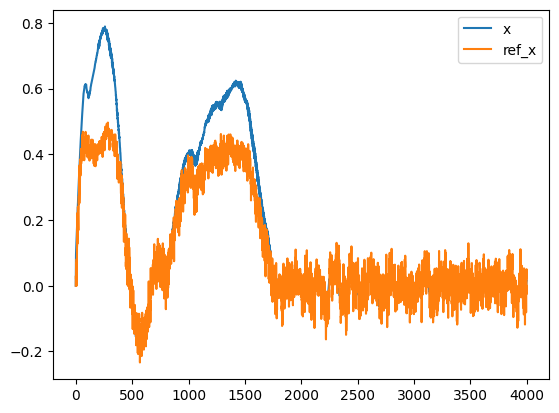

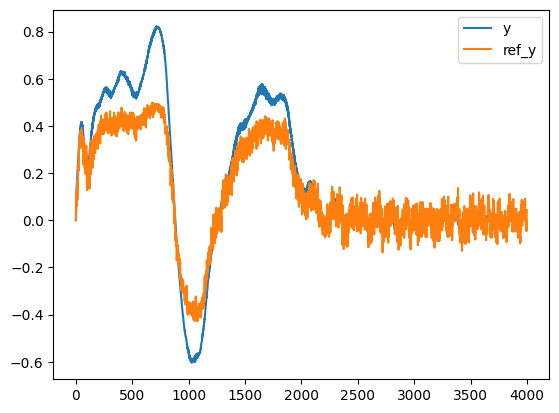

In [17]:
# Nothing
plot_inputs(u_list, reference_list)

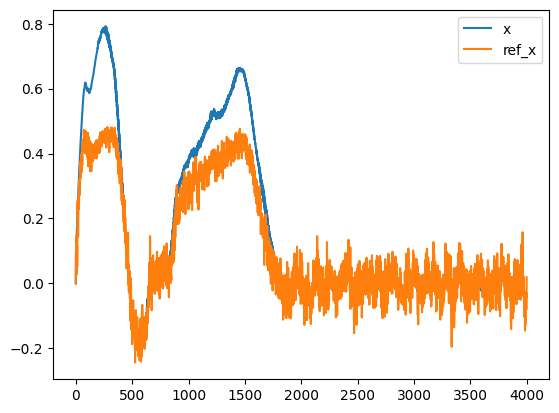

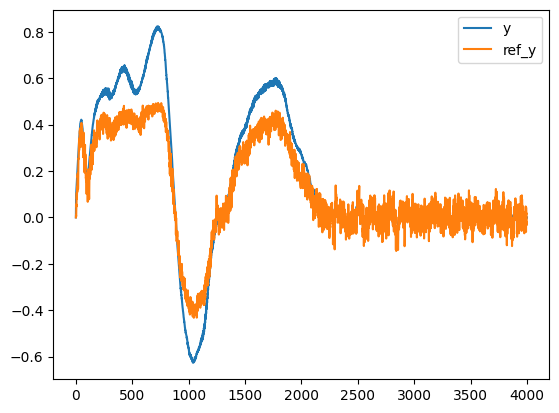

In [31]:
# PID Only
plot_inputs(u_list, reference_list)

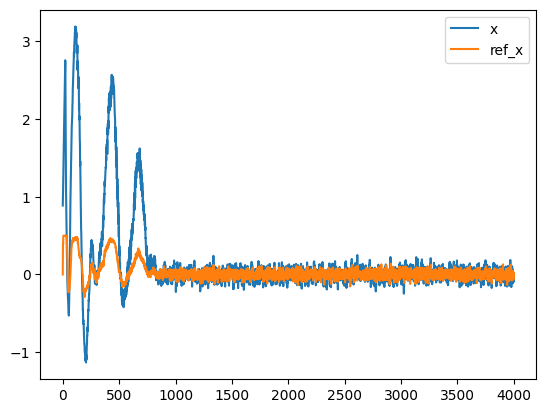

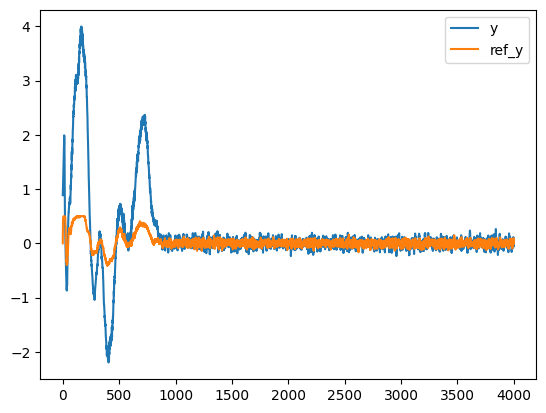

In [42]:
# LQR Only
plot_inputs(u_list, reference_list)

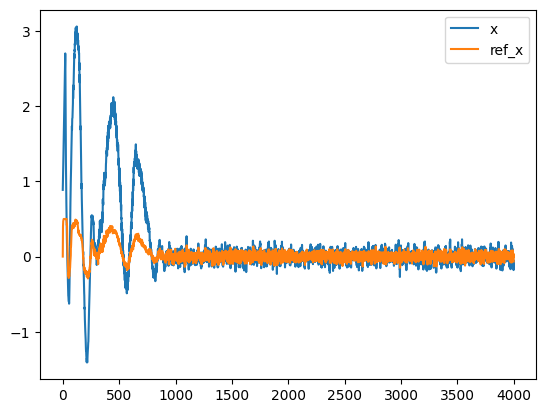

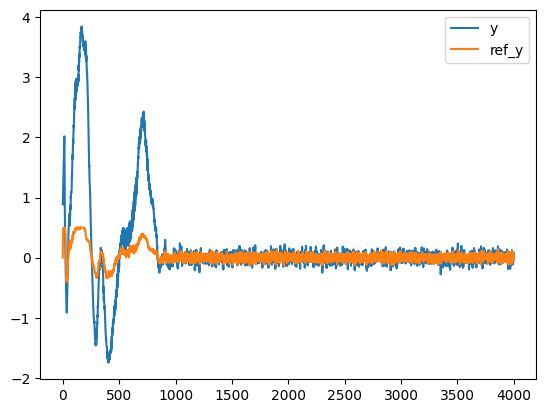

In [53]:
# PID-LQR
plot_inputs(u_list, reference_list)